In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import cross_validation

In [2]:
Auto = pd.read_csv('../Data/Auto.csv', index_col=0)

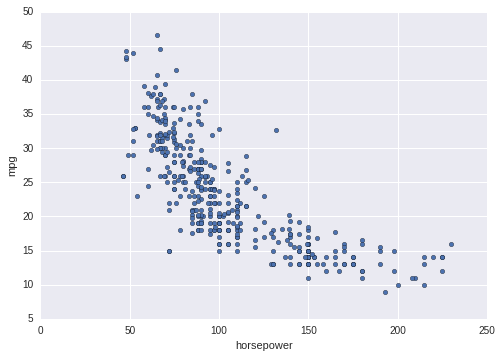

In [3]:
Auto.plot(x='horsepower',y='mpg',kind='scatter')

In [6]:
X = Auto['horsepower'].values[:,np.newaxis]
y = Auto['mpg'].values
lr = linear_model.LinearRegression()
glm = lr.fit(X,y)
print("Intercept: {} \n Coef: {}".format(glm.intercept_,glm.coef_))

Intercept: 39.93586102117045 
 Coef: [-0.15784473]


In [7]:
# LOOCV
from sklearn.cross_validation import LeaveOneOut
lr = linear_model.LinearRegression()
scores = cross_validation.cross_val_score(lr, X, y, cv=LeaveOneOut(len(X)), scoring='mean_squared_error')
print(scores.mean(), scores.std()) # 
print(scores.min(), scores.max()) # wow

-24.2315135179 36.7973150364
-289.448955464 -0.00354617604567


In [8]:
# cross_val_score is designed to maximize, and thus returns negated errors
# read about cross validation in sklearn here: http://scikit-learn.org/stable/modules/cross_validation.html
# read about the scoring function behavior here: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
scores[0:10]

array([ -2.02001002e+00,  -1.25092412e+00,  -3.06805164e+00,
        -6.79901984e-02,  -7.08255629e-01,  -4.13566745e+01,
        -8.13755358e+01,  -6.71494767e+01,  -9.70498847e+01,
        -2.63430368e+01])

In [9]:
# to make sure I understand, here's a few examples of what's happening
from sklearn.metrics import make_scorer, mean_squared_error
def MSE(y,y_hat):
    return ((y-y_hat)**2).mean()
print(cross_validation.cross_val_score(lr, X, y, cv=LeaveOneOut(len(X)), scoring=make_scorer(MSE)).mean())
print(cross_validation.cross_val_score(lr, X, y, cv=LeaveOneOut(len(X)), scoring=make_scorer(MSE, greater_is_better=False)).mean())
print(cross_validation.cross_val_score(lr, X, y, cv=LeaveOneOut(len(X)), scoring=make_scorer(mean_squared_error, greater_is_better=True)).mean())

24.2315135179
-24.2315135179
24.2315135179


In [10]:
model1 = sm.OLS(Auto['mpg'], sm.add_constant(Auto['horsepower']))
res1 = model1.fit()

In [11]:
# took a little digging to find that influence diagonal used in the R lab, but i found it!
def loocv(results):
    return ((results.resid/(1-results.get_influence().hat_diag_factor))**2).mean()

In [12]:
loocv(res1)

24.235228944680877

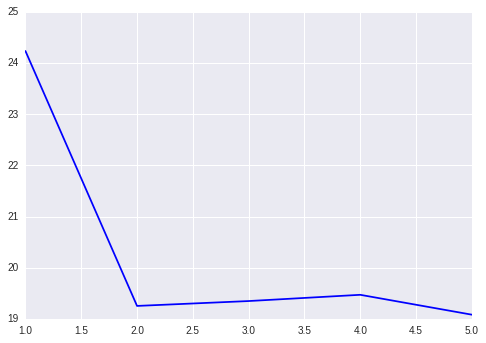

In [13]:
# as far as I know statsmodels does not have that poly() helper function
cv_errors = []
degrees = list(range(1,6))
exog = pd.DataFrame()
for d in degrees:
    exog[d] = Auto['horsepower']**d
    res = sm.OLS(Auto['mpg'], sm.add_constant(exog)).fit()
    cv_errors.append(loocv(res))
plt.plot(degrees,cv_errors,'b')

In [21]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = Auto['horsepower'].values[:,np.newaxis]
y = Auto['mpg'].values

cv5_errors = []
cv10_errors = []
cv_loocv_errors = []
# making pipeline to use
for d in degrees:
    model = make_pipeline(PolynomialFeatures(d),linear_model.LinearRegression())
    scores = cross_validation.cross_val_score(model, X, y, cv=cross_validation.LeaveOneOut(len(y)), scoring='mean_squared_error')
    cv_loocv_errors.append(-scores.mean())
    scores = cross_validation.cross_val_score(model, X, y, cv=5, scoring='mean_squared_error')
    cv5_errors.append(-scores.mean())
    scores = cross_validation.cross_val_score(model, X, y, cv=10, scoring='mean_squared_error')
    cv10_errors.append(-scores.mean())
    

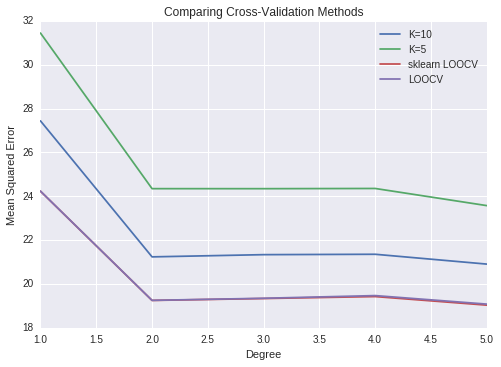

In [25]:
# I have tried a bunch of stuff, but for the life of me I can not get K=10 to match up with LOOCV like it does in the lab
# The PolynomialFeatures does work a little differently, but even hard-coding the polynomials I couldn't get it
# Please if figure out what's going on, please share
plt.plot(degrees,cv10_errors, label='K=10')
plt.plot(degrees,cv5_errors, label='K=5')
plt.plot(degrees,cv_loocv_errors, label='sklearn LOOCV')
plt.plot(degrees,cv_errors, label='LOOCV')
plt.title('Comparing Cross-Validation Methods')
plt.xlabel('Degree')
plt.ylabel('Mean Squared Error')
plt.legend()

In [55]:
Portfolio = pd.read_csv('../Data/Portfolio.csv' )
del Portfolio['Unnamed: 0']

In [56]:
# numpy uses unbiased estimators unlike R
def alpha(x,y):
    vx = np.var(x)
    vy = np.var(y)
    cov_xy = np.cov(x,y)[1][0]
    return (vy-cov_xy)/(vx+vy-2*cov_xy)

In [57]:
alpha(Portfolio.X, Portfolio.Y)

0.57665115161041181

In [69]:
def alpha_fn(data,index):
    data = data.loc[index]
    return alpha(data['X'], data['Y'])

In [70]:
alpha_fn(Portfolio, [i for i in range(len(Portfolio))])

0.57665115161041181

In [78]:
def boot(data, fn, R):
    n = len(data)
    scores = [fn(data, np.random.choice(n,n)) for _ in range(R)]
    return scores

In [98]:
boot_out = boot(Portfolio,alpha_fn, 1000)
np.mean(boot_out), np.std(boot_out)

(0.57319627844083332, 0.091923632475125805)

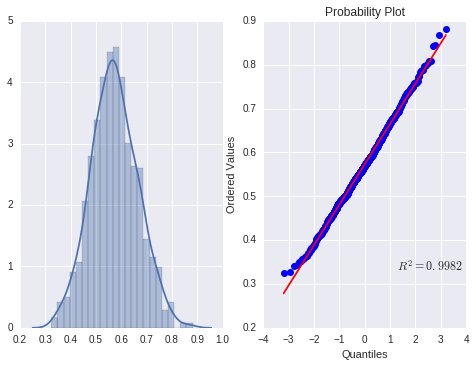

In [153]:
from scipy.stats import probplot

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
sns.distplot(boot_out, ax=ax1)
a = probplot(boot_out, plot=ax2)


In [102]:
data = pd.read_csv("../Data/5.R.RData.csv", usecols=['X1','X2','y'])

In [103]:
data.head()

,X1,X2,y
0,1.297720,0.805921,0.298968
1,1.267323,0.799034,0.318134
2,1.236882,0.792169,0.337201
3,1.206317,0.785296,0.356121
4,1.175553,0.778385,0.374842


In [104]:
model1 = sm.OLS(data['y'], sm.add_constant(data[['X1','X2']]))
res1 = model1.fit()

In [136]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     66.14
Date:                Thu, 31 Mar 2016   Prob (F-statistic):           1.06e-27
Time:                        10:25:03   Log-Likelihood:                -810.66
No. Observations:                1000   AIC:                             1627.
Df Residuals:                     997   BIC:                             1642.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2658      0.020     13.372      0.000         0.227     0.305
X1             0.1453      0.026      5.604      0.000         0.094     0.196
X2             0.3134      0.029     10.722      0.000         0.256     0.371
==============================================================================
Omnibus:                        9.703   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               13.694
Skew:                          -0.065   Prob(JB):                      0.00106
Kurtosis:                       3.558   Cond. No.                         2.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

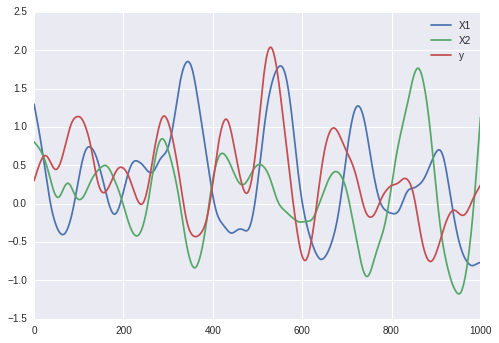

In [137]:
data.plot()

In [155]:
def beta_fn(data,index):
    data = data.loc[index]
    return sm.OLS(data['y'], sm.add_constant(data[['X1','X2']])).fit().params['X1']

0.146449751402 0.0284683417899


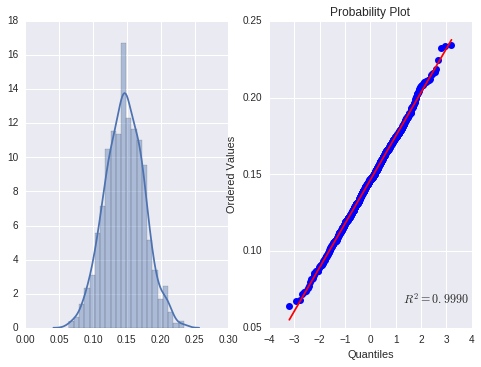

In [161]:
boot_out = boot(data,beta_fn, 1000)
print(np.mean(boot_out), np.std(boot_out))
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
sns.distplot(boot_out, ax=ax1)
a = probplot(boot_out, plot=ax2)

In [176]:
def gen_index():
    ix = []
    for i in np.random.randint(0,9,10):
        start = 100*i + 1
        end = 100*(i+1) + 1
        ix.extend(range(start,end))
    return ix

In [189]:
block_boot = [beta_fn(data,gen_index()) for _ in range(1000)]

mean = 0.15338623183059116 
 std = 0.22839740456825947


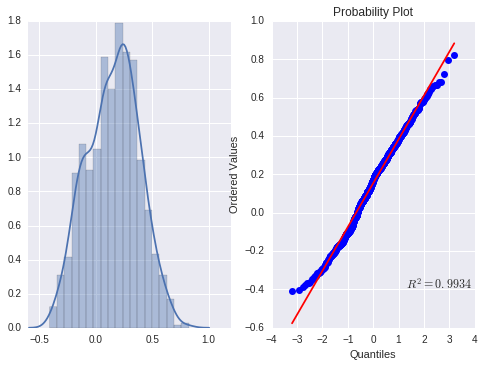

In [190]:
# my std is slightly higher...
print("mean = {} \n std = {}".format(np.mean(block_boot), np.std(block_boot)))
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
sns.distplot(block_boot, ax=ax1)
a = probplot(block_boot, plot=ax2)

In [181]:
len(data)

1000